# Evolutionary Camouflage Versus a Learning Predator
EvoCamoVsLearningPredator.ipynb

Just a copy of Evo_Camo_vs_Static_FCD.ipynb as of 20220403


In [1]:
# # Shared "communication" directory on Drive.
# shared_directory = '/content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/'

# # Pathname of pre-trained Keras/TensorFlow model
# saved_model_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

# PredatorEye directory on Drive.
pe_directory = '/content/drive/My Drive/PredatorEye/'

# Shared "communication" directory on Drive.
# shared_directory = '/content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/'
shared_directory = pe_directory + 'evo_camo_vs_static_fcd/'

# Directory for pre-trained Keras/TensorFlow models on Drive.
# saved_model_directory = '/content/drive/My Drive/PredatorEye/saved_models/'
saved_model_directory = pe_directory + 'saved_models/'

# Pathname of pre-trained Keras/TensorFlow model
# trained_model = saved_model_directory + '20220202_1211_Find_3_Disks_complex'
# trained_model = saved_model_directory + '20220222_1747_F3D_augmented_rc4'
# trained_model = saved_model_directory + '20220227_0746_F3D2_a'
# trained_model = saved_model_directory + '20220304_1135_FCD5_a'
trained_model = saved_model_directory + '20220321_1711_FCD6_rc4'
model = []

# Directory on Drive for storing fine-tuning dataset.
fine_tuning_directory = shared_directory + 'fine_tuning/'

my_prefix = "find_"
other_prefix = "camo_"

my_suffix =  ".txt"
# other_suffix = ".jpeg"
other_suffix = ".png"

fcd_image_size = 1024
fcd_disk_size = 201

import time
import PIL
################################################################################
# TODO 20220420

from pathlib import Path

# Came upon Python 3's 'pathlib' https://docs.python.org/3/library/pathlib.htm
# while fixing a bug. I think the API below is obsolete and should be replaced.
from os import listdir
from os import remove
from os.path import join
from os.path import split
from os.path import isfile
################################################################################
from tensorflow import keras
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

TensorFlow version: 2.8.0


# Ad hoc “predator server”

In [2]:
# Top level: wait for camo_xxx.jpeg files to appear, respond with find_xxx.txt
def start_run(step = 0):
    if step == 0:
        print('Start run in', shared_directory )
        list_unexpected_files(shared_directory)
    else:
        print('Continue run at step', step, ' in', shared_directory)
    while True:
        performStep(step, shared_directory)
        step += 1

# Continue from from the last camo_xxx.jpeg file.
def restart_run():
    start_run(newest_file_from_other(shared_directory))

# Single step: wait for camo file, write response, delete previous response.
def performStep(step, directory):
    waitForReply(step, shared_directory)
    print('Write file', step)
    writeResponseFile(step, shared_directory)
    deleteMyFile(step - 1, shared_directory)

# Read image file for step, apply pre-trained model, write response file.
def writeResponseFile(step, directory):
    # Read image file and check for expected format.
    image_pathname = makeOtherPathname(step, directory)
    pixel_tensor = df.read_image_file_as_pixel_tensor(image_pathname)
    assert df.check_pixel_tensor(pixel_tensor), ('wrong file format: ' +
                                                 image_pathname)
    # Run pre-trained model on new image.
    prediction = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
    # Generate response file.
    response_string = str(prediction[0]) + " " + str(prediction[1])
    print('response_string ' + "'" + response_string + "'")
    verify_comms_directory_reachable()
    with open(makeMyPathname(step, directory), 'w') as file:
        file.write(response_string)
    print("wrote response file", makeMyPathname(step, directory))
    # Predator learns from recent experience.
    fine_tune_predator(pixel_tensor, prediction, step, directory)

# Delete the given file, usually after having written the next one.
def deleteMyFile(step, directory):
    path = makeMyPathname(step, directory)
    if isfile(path):
        remove(path)

# From pathname for file of given step number from the "other" agent.
def makeOtherPathname(step, directory):
    return directory + other_prefix + str(step) + other_suffix

# Form pathname for file of given step number from "this" agent.
def makeMyPathname(step, directory):
    return directory + my_prefix + str(step) + my_suffix

def makePreyPathname(step, directory):
    return directory + 'prey_' + str(step) + '.txt'

# Wait until other agent's file for given step appears.
def waitForReply(step, directory):
    print('start waiting for  ', makeOtherPathname(step, directory))
    start_time = time.time()
    while not isFilePresent(makeOtherPathname(step, directory)):
        time.sleep(2)  # wait 2 sec
    print('done waiting for   ', makeOtherPathname(step, directory))
    print('Elapsed time:', int(time.time() - start_time), 'seconds.')

# Like fs::exists()
def isFilePresent(file):
    result = False
    (directory, filename) = split(file)
    for i in listdir(directory):
        if i == filename:
            result = True
    return result

# Actually I guess the counterparty may have already written its first...
def list_unexpected_files(directory):
    directory_contents = listdir(directory)
    if directory_contents:
        print('Unexpected files:', directory_contents)

# Returns the step number of the newest file from "other" in given directory.
# (So if "camo_573.jpeg" is the only "other" file there, returns int 573)
def newest_file_from_other(directory):
    steps = [0]  # Default to zero in case dir is empty.
    for filename in listdir(directory):
        if other_prefix == filename[0:len(other_prefix)]:
            steps.append(int(filename.split(".")[0].split("_")[1]))
    return max(steps)

# Accumulated a new “training set” of the most recent N steps seen so far. (See
# https://cwreynolds.github.io/TexSyn/#20220421 and ...#20220424 for discussion
# of this parameter.)
# max_training_set_size = 200
# max_training_set_size = 100
max_training_set_size = float('inf') # keep ALL steps in training set, use GPU.

fine_tune_images = []
fine_tune_labels = []

# Apply fine-tuning to (originally pre-trained) predator. Use recent steps as
# training set. Assume they were "near misses" and so training label is actual
# (ground truth) center of disk nearest prediction. Keep a max number of old
# steps to allow gradually forgetting the earliest part of the run.
def fine_tune_predator(pixel_tensor, prediction, step, directory):
    # Assume the predator was "aiming for" that one but missed by a bit.
    label_for_fine_tuning = center_of_nearest_prey(prediction, step, directory)

    # Accumulate the most recent "max_training_set_size" training samples.
    global fine_tune_images
    global fine_tune_labels
    fine_tune_images.append(pixel_tensor)
    fine_tune_labels.append(label_for_fine_tuning)

    # If training set has become too large, slice off first element of each.
    if len(fine_tune_images) > max_training_set_size:
        fine_tune_images = fine_tune_images[1:]
        fine_tune_labels = fine_tune_labels[1:]
        # print('Trim fine-tune training set to max_training_set_size.')

    # Convert training data list to np arrays
    images_array = np.array(fine_tune_images)
    labels_array = np.array(fine_tune_labels)
    print('images_array.shape =', images_array.shape)
    print('labels_array.shape =', labels_array.shape)

    # Do fine-tuning training step using data accumulated during run.
    history = model.fit(x=images_array, y=labels_array)
    # Keep log of in_disk metric:
    write_in_disk_log(step, history)

    # TEMP keep?
    # visualize change from train step:
    new_prediction = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
    before = df.dist2d(prediction, label_for_fine_tuning)
    after = df.dist2d(new_prediction, label_for_fine_tuning)
    d = after - before
    note = 'INCREASED:'
    if before > after :
        note = 'DECREASED:'
    print(note, "{:.4f}".format(d),
          '(before:', "{:.4f}".format(before),
          'after:', "{:.4f}".format(after), ')')

# 20220408 
# Given the xy prediction from the current predator model, read the ground truth
# prey locations in the "prey_n.txt" file, return the one nearest to the current
# prediction. Effectively, assume the predator was "aiming for" that one but
# missed by a bit.
def center_of_nearest_prey(predict, step, directory):
    prey_centers = read_3_centers_from_file(step, directory)
    # SURELY there is a more "pythonic" way to do this (select min distance)
    min_distance = float('inf')
    nearest_center = []
    for prey_center in prey_centers:
        # print('prey_center =', prey_center)
        distance = df.dist2d(prey_center, predict)
        # print('distance =', distance)
        if min_distance > distance:
            min_distance = distance
            nearest_center = prey_center
        # print('min_distance =', min_distance)
        # print('nearest_center =', nearest_center)
    return nearest_center

# Read ground truth prey center location data provided in "prey_n.txt" file.
def read_3_centers_from_file(step, directory):
    # Read contents of file as string.
    verify_comms_directory_reachable()
    with open(makePreyPathname(step, directory), 'r') as file:
        prey_centers_string = file.read()
    # Split string at whitespace, map to 6 floats, reshape into 3 xy pairs.
    return np.reshape(list(map(float, prey_centers_string.split())), (3, 2))

# Keep log of in_disk metric.
def write_in_disk_log(step, history):
    if step % 10 == 0:
        in_disk = history.history["in_disk"][0]
        pathname = shared_directory + 'in_disk_log.csv'
        verify_comms_directory_reachable()
        with open(pathname, 'a') as file:
            if step == 0:
                file.write('step,in_disk\n')
            file.write(str(step) + ',' + "{:.4f}".format(in_disk) + '\n')

# Just wait in retry loop if shared "comms" directory become unreachable.
# Probably will return shortly, better to wait than signal a file error.
# (This is called from places with a local "directory" but it uses global value.)
def verify_comms_directory_reachable():
    seconds = 0
    # shared_directory_pathname = Path(shared_directory)
    # while not shared_directory_pathname.is_dir():
    while not Path(shared_directory).is_dir():
        print("Shared “comms” directory,", shared_directory, 
              "has been inaccessible for", seconds, "seconds.")
        time.sleep(1)  # wait 1 sec
        seconds += 1


# Read pre-trained model

In [3]:
# Read pre-trained TensorFlow "predator vision" model.

print('Reading pre-trained model from:', trained_model)
# ad hoc workaround suggested on https://stackoverflow.com/q/66408995/1991373
#
# dependencies = {
#     'hamming_loss': tfa.metrics.HammingLoss(mode="multilabel", name="hamming_loss"),
#     'attention': attention(return_sequences=True)
# }
#
# dependencies = {
#     'valid_accuracy': ValidAccuracy
# }

# Calculates RELATIVE disk radius on the fly -- rewrite later.
def fcd_disk_radius():
    return (float(fcd_disk_size) / float(fcd_image_size)) / 2

# Given two tensors of 2d point coordinates, return a tensor of the Cartesian
# distance between corresponding points in the input tensors.
def corresponding_distances(y_true, y_pred):
    true_pos_x, true_pos_y = tf.split(y_true, num_or_size_splits=2, axis=1)
    pred_pos_x, pred_pos_y = tf.split(y_pred, num_or_size_splits=2, axis=1)
    dx = true_pos_x - pred_pos_x
    dy = true_pos_y - pred_pos_y
    distances = tf.sqrt(tf.square(dx) + tf.square(dy))
    return distances

# 20211231 copied from Find_Concpocuous_Disk
def in_disk(y_true, y_pred):
    distances = corresponding_distances(y_true, y_pred)
    # relative_disk_radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2

    # From https://stackoverflow.com/a/42450565/1991373
    # Boolean tensor marking where distances are less than relative_disk_radius.
    # insides = tf.less(distances, relative_disk_radius)
    insides = tf.less(distances, fcd_disk_radius())
    map_to_zero_or_one = tf.cast(insides, tf.int32)
    return map_to_zero_or_one

dependencies = { 'in_disk': in_disk }

model = keras.models.load_model(trained_model, custom_objects=dependencies)

Reading pre-trained model from: /content/drive/My Drive/PredatorEye/saved_models/20220321_1711_FCD6_rc4


# Run test

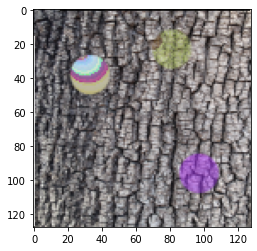

FileNotFoundError: ignored

In [6]:
# Normally start from step 0, or if an "other" file exists
# (eg 'camo_123.jpeg') then restart from that point.
################################################################################
# restart_run()


# TODO WIP on saving tine-tuning dataset to Drive

# def read_image_file_as_pixel_tensor(image_pathname):
#     # Read image file.
#     image = PIL.Image.open(image_pathname)
#     # Convert to numpy pixel tensor as 32 bit floats.
#     pixel_tensor = np.asarray(image, dtype=np.float32)
#     # Scale input image data to range [0, 1]
#     pixel_tensor = np.interp(pixel_tensor, [0, 255], [0, 1]).astype(np.float32)
#     return pixel_tensor


# # Read image file at given pathname, pre-process for use in training model.
# # def make_complex_example(image_pathname):
# def f3d_make_training_example(image_pathname):
#     # Read image file.
#     pixels = df.read_image_file_as_pixel_tensor(image_pathname)
#     # Check for expected format.
#     if not df.check_pixel_tensor(pixels):
#         msg = 'wrong image format, shape='+str(pixels.shape)+': '+image_pathname
#         assert False, msg    
#     # Parse disk center position from file name.
#     filename = os.path.basename(image_pathname)
#     center_position = df.fcd_normalized_xy(filename, pixels)
#     return (pixels, center_position)


# def test_jig():
#     df.reset_random_seeds()
#     # pn = '/content/drive/My Drive/temp/crqtVaibvq_26_105.png'
#     pn = '/content/drive/My Drive/temp/jQREPLQyuL_33_39.png'
#     ti, tl = f3d_make_training_example(pn)
#     df.draw_image(ti, tl)
#     for i in range(10):
#         mi, ml = f3d_modify_training_example(ti, tl)
        
#         print('mi.shape =', mi.shape)
#         print('ml.shape =', ml.shape)

#         df.draw_image(mi, ml)
# test_jig()


def test():
    pn = '/content/drive/My Drive/temp/jQREPLQyuL_33_39.png'
    pixels = df.read_image_file_as_pixel_tensor(pn)
    df.draw_image(pixels, (0, 0))


    image = PIL.Image.open(pn)
    # TODO ERROR, needs to construct directory #################################
    image.save(fine_tuning_directory + "test.png")


test()

################################################################################